<a href="https://colab.research.google.com/github/AishwaryaNambissan/Code/blob/main/LDA_FinalDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installations and Packages

In [1]:
import pandas as pd
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim import models

%pip install ijson
import ijson

import pandas as pd

from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_short
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import strip_non_alphanum
from gensim.parsing.preprocessing import strip_short
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS
from nltk.tokenize import word_tokenize

import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

from collections import Counter
import csv
from wordcloud import WordCloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.8/111.8 kB 3.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Printing out information about the dataset

In [3]:
file =  '/content/gdrive/MyDrive/Colab Notebooks/extracted_files/json/artificial_intelligence.json'
affs = set()
author_names = set()
content = []
doi=[]
counter = 0
try:
    with open(file, 'r') as f:
        # Parse the JSON objects one by one
        parser = ijson.items(f, 'item')

        # Iterate over the JSON objects
        for item in parser:
          counter = counter + 1
          try:
            # Process each JSON object as needed
            if 'abstract' in item.keys() and 'title' in item.keys():
              title = ' '.join(item['title'])
              content.append(item['abstract']+ " " + title)
              doi.append(item.get('DOI', ''))

            if 'author' in item.keys():
              authors = item['author']
              for val in authors:
                # Both given and family names have to exist to be counted
                if 'given' in val.keys() and 'family' in val.keys():
                # Extract the name of the author from the given and family names
                  name = val['given'] + " " + val['family']
                # Add the author's name to the set of authors
                  author_names.add(name)

                if 'affiliation' in val.keys():
                  # Extract the name of the author
                  affiliations = val['affiliation']
                  if len(affiliations) > 0:
                    for aff in affiliations:
                      if 'name' in aff.keys():
                        name = aff['name']
                        # Add the author's affiliation to the set of affiliations
                        affs.add(name)

          except Exception as e:
              print("Error processing JSON item:", str(e))
except FileNotFoundError:
  print("File not found:", file)
except Exception as e:
  print("Error reading file:", str(e))

print("Number of records", counter)
print("Number of affiliations:", len(affs))
print("Number of co-authors:", len(author_names))


Number of records 501629
Number of affiliations: 163722
Number of co-authors: 736857


Creating the dataframe with required feature


In [5]:
df = pd.DataFrame(columns=['content', 'doi'])
# Convert JSON to DataFrame Using read_json()
df['content'] = pd.DataFrame(content)
df['doi'] = pd.DataFrame(doi)


# Checking for missing values
df.isnull().sum()

# Dropping those columns with null values for abstract or title
df = df.dropna()
df.shape
df.head()

,content,doi
0,<jats:p> Artificial immune system is inspired ...,10.1142/s0218213012500315
1,<jats:p> Accurate time series forecasting are ...,10.1142/s0218213011000462
2,<jats:p> This paper addresses the problem of e...,10.1142/s0218213019400086
3,<jats:p> Recent trends in educational technolo...,10.1142/s0218213019400062
4,<jats:p> As the dairy products have a short co...,10.1142/s0218213020500086


Preprocessing and Cleaning the data

In [6]:
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, strip_non_alphanum,  lambda x: strip_short(x, minsize=4)]

filtered_text = []
for item in df['content'].astype(str):
  filtered_text.append(preprocess_string(item, CUSTOM_FILTERS))


Lemmatization

In [7]:
import nltk

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
lemmatized_words = [[lemmatizer.lemmatize(word) for word in sublst] for sublst in filtered_text]


In [ ]:
print("One row of Lemmatized words")
print(lemmatized_words[0])

One row of Lemmatized words
['artificial', 'immune', 'system', 'inspired', 'natural', 'immune', 'system', 'solving', 'computational', 'problem', 'immunological', 'principle', 'that', 'primarily', 'used', 'artificial', 'immune', 'system', 'clonal', 'selection', 'principle', 'immune', 'network', 'theory', 'negative', 'selection', 'mechanism', 'these', 'principle', 'have', 'been', 'applied', 'anomaly', 'detection', 'pattern', 'recognition', 'computer', 'network', 'security', 'dynamic', 'environment', 'learning', 'robotics', 'data', 'analysis', 'optimization', 'scheduling', 'timetabling', 'this', 'paper', 'describes', 'these', 'three', 'immunological', 'principle', 'were', 'adapted', 'previous', 'researcher', 'their', 'artificial', 'immune', 'system', 'model', 'algorithm', 'finally', 'application', 'various', 'artificial', 'immune', 'system', 'various', 'domain', 'summarized', 'time', 'line', 'immunology', 'artificial', 'immune', 'system']


Removing stop words

In [9]:
nltk.download('punkt')

stop_words = STOPWORDS.union(set(['jats', 'ai', 'artificial', 'intelligence', 'research','technology','article', 'pattern','compared',
                                  'development', 'paper', 'application', 'method','deep','algorithm', 'problem', 'model', 'iso', 'function',
                                  'noise', 'sample', 'layer', 'optimization', 'solution','term','including', 'factor','tool','main','experimental',
                                  'optimal', 'parameter', 'predict', 'forecast', 'cluster','classifier', 'label', 'class','input','world',
                                  'test', 'training', 'case', 'level', 'give', 'focus','change','current','point','important','number','strategy',
                                  'real', 'however', 'review', 'need', 'various', 'many', 'solve', 'analyze', 'human','significant','source',
                                  'include', 'datasets','dataset','image', 'approach', 'accuracy', 'information','component','potential',
                                  'also', 'time', 'show',  'provide', 'task', 'make','existing','multiple','making','activity','search',
                                  'performance', 'knowledge', 'user', 'feature', 'proposed','propose','year','related','efficient','rate',
                                  'process', 'system', 'well', 'study','form','effective','example','better','characteristic','support',
                                  'different', 'high', 'improve', 'design', 'recognition','specific','finally','novel','order','purpose',
                                  'train', 'compare', 'field', 'apply', 'develop', 'based','content','impact','possible','error','presented',
                                  'technique', 'analysis', 'present', 'work','condition','implementation','evaluation','increase','target',
                                  'learn', 'machine', 'language', 'large','issue','value','given','higher','context','scale','complex',
                                  'intelligent', 'base', 'neural', 'network', 'framework','learning','developed','best','multi','fuzzy',
                                  'result', 'use', 'supervised', 'representation', 'domain', 'architecture','provides','obtained','like',
                                  'prediction', 'classification', 'natural', 'conference', 'data','identify','concept','available','world',
                                  'conclusion', 'objective', 'abstract','background', 'author', 'disclosure', 'title', 'computer', 'agent',
                                  'challenge','processing', 'future', 'recent', 'transfer', 'state', 'yang','evolutionary','program','combination',
                                  'vector','chapter','theory','aim','addition', 'step','cost','type','part','efficiency','complexity',
                                  'comparison','set','experiment','measure','quality','operation','difference','direction','practice',
                                  'platform','range','researcher','area','stage','object','structure','decision','mean','finding','response',
                                  'effect','group','effectiveness','size','people','way','science','question','role','requirement','goal',
                                  'implement','nan', 'mechanism', 'modeling','second','considered','space','simulation','internet',
                                  'standard','variable','physical','interaction','local','methodology','spatial','smart','significantly',
                                  'a', 'an', 'the', 'in', 'on', 'at', 'from', 'to', 'with', 'over', 'under','and', 'but', 'or', 'so', 'nor', 'for',
                                  'yet', 'i', 'you', 'he', 'she','it', 'we', 'they', 'me', 'him', 'her', 'us', 'them','is', 'am', 'are', 'was',
                                  'were', 'be', 'been', 'being','have', 'has', 'had', 'do', 'does', 'did', 'will', 'shall','can', 'could', 'would',
                                  'should', 'may', 'might', 'must', 'ought', 'that','this', 'these', 'those', 'how', 'what', 'why', 'by', 'their',
                                  'of', 'as', 'there','within', 'which']))

s = ""
print(stop_words)
cleaned_text_list = []
for line in lemmatized_words:
  s = " ".join(line)
  tokenized_text = word_tokenize(s)
  cleaned_text = [word for word in tokenized_text if word.lower() not in stop_words]
  cleaned_text_list.append(cleaned_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


frozenset({'internet', 'whereupon', 'characteristic', 'sometimes', 'among', 'title', 'role', 'or', 'doesn', 'language', 'area', 'few', 'compare', 'although', 'un', 'say', 'everywhere', 'content', 'conference', 'out', 'both', 'hasnt', 'network', 'they', 'evaluation', 'strategy', 'because', 'bottom', 'doing', 'jats', 'etc', 'however', 'analysis', 'and', 'review', 'information', 'five', 'does', 'made', 'theory', 'every', 'ever', 'somewhere', 'any', 'mine', 'nan', 'factor', 'quite', 'when', 'propose', 'of', 'wherever', 'operation', 'about', 'result', 'you', 'down', 'formerly', 'user', 'nevertheless', 'ours', 'effective', 'activity', 'across', 'optimization', 'datasets', 'class', 'before', 'type', 'prediction', 'interest', 'deep', 'together', 'example', 'seems', 'whose', 'four', 'whenever', 'everything', 'against', 'ai', 'itself', 'her', 'almost', 'km', 'their', 'off', 'issue', 'model', 'available', 'performance', 'go', 'kg', 'including', 'considered', 'regarding', 'proposed', 'finally', 'c

Creating vocabulary dictionary and document term matrix

In [10]:
dictionary = corpora.Dictionary(cleaned_text_list)
doc_term_matrix = [dictionary.doc2bow(con) for con in cleaned_text_list]
print(doc_term_matrix[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 7), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 4), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1)]


Finding optimal number of topics using coherence score

In [11]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [12]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=cleaned_text_list, start=10, limit=31, step=1)


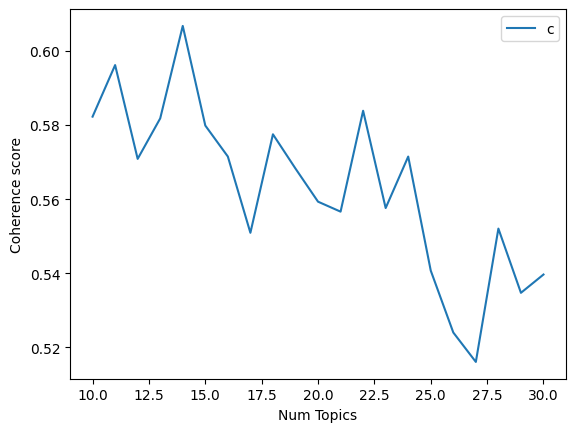

In [13]:
# Show graph
limit=31; start=10; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plot_coherence = plt.gcf()
plt.show()
plot_coherence.savefig("Coherence_plot.png")

In [14]:
max_cv = max(coherence_values)
m_with_max_cv = None


# Print the coherence scores and m with max cv in the range 10 to 30
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    if 10 <= m <= 30:
        if max_cv is None or cv >= max_cv:
            max_cv = cv
            m_with_max_cv = m

print("Optimum number of topics: m with max cv:", m_with_max_cv)

Num Topics = 10  has Coherence Value of 0.5823
Num Topics = 11  has Coherence Value of 0.5962
Num Topics = 12  has Coherence Value of 0.5709
Num Topics = 13  has Coherence Value of 0.5818
Num Topics = 14  has Coherence Value of 0.6067
Num Topics = 15  has Coherence Value of 0.5799
Num Topics = 16  has Coherence Value of 0.5715
Num Topics = 17  has Coherence Value of 0.5509
Num Topics = 18  has Coherence Value of 0.5775
Num Topics = 19  has Coherence Value of 0.5683
Num Topics = 20  has Coherence Value of 0.5593
Num Topics = 21  has Coherence Value of 0.5566
Num Topics = 22  has Coherence Value of 0.5839
Num Topics = 23  has Coherence Value of 0.5576
Num Topics = 24  has Coherence Value of 0.5715
Num Topics = 25  has Coherence Value of 0.5407
Num Topics = 26  has Coherence Value of 0.524
Num Topics = 27  has Coherence Value of 0.5161
Num Topics = 28  has Coherence Value of 0.5521
Num Topics = 29  has Coherence Value of 0.5347
Num Topics = 30  has Coherence Value of 0.5397
Optimum number

In [15]:
# Optimum number of topics is m_with_max_cv
num_topics = m_with_max_cv
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, random_state=100,
                chunksize=1000, passes=50,iterations=100)


In [16]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()


0: 0.029*"span" + 0.025*"text" + 0.021*"breast" + 0.011*"speech" + 0.010*"mining" + 0.010*"word" + 0.008*"style" + 0.008*"semantic" + 0.008*"extraction" + 0.007*"clustering"

1: 0.101*"patient" + 0.047*"clinical" + 0.045*"cancer" + 0.043*"disease" + 0.033*"medical" + 0.032*"covid" + 0.030*"diagnosis" + 0.028*"treatment" + 0.018*"risk" + 0.014*"diagnostic"

2: 0.015*"regression" + 0.010*"selection" + 0.009*"random" + 0.009*"tree" + 0.009*"forest" + 0.009*"distribution" + 0.009*"uncertainty" + 0.008*"forecasting" + 0.008*"index" + 0.007*"statistical"

3: 0.017*"digital" + 0.017*"social" + 0.010*"medium" + 0.007*"society" + 0.007*"scientific" + 0.006*"journal" + 0.006*"experience" + 0.006*"life" + 0.006*"public" + 0.006*"virtual"

4: 0.062*"education" + 0.059*"student" + 0.058*"university" + 0.032*"game" + 0.028*"teaching" + 0.028*"school" + 0.026*"educational" + 0.021*"child" + 0.018*"skill" + 0.016*"course"

5: 0.018*"management" + 0.013*"service" + 0.013*"digital" + 0.012*"industry" + 

Perplexity and Coherence score of the model

In [17]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=counter))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_words, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.004134424448077

Coherence Score:  0.5186607672872675


Visualization

In [18]:
# Get the dominant topic and its associated cluster for each document
cluster_labels = []
for doc in doc_term_matrix:
    doc_topics = lda_model.get_document_topics(doc)
    dominant_topic = max(doc_topics, key=lambda x: x[1])[0]
    cluster_labels.append(dominant_topic)


# Count the number of documents in each cluster and display
cluster_counts = Counter(cluster_labels)

for key, value in cluster_counts.items():
    print(key, ":", value)


10 : 2639
2 : 8500
11 : 12296
0 : 7201
5 : 22190
9 : 17247
8 : 7139
3 : 16441
6 : 4602
4 : 2024
12 : 5708
7 : 1117
1 : 4981
13 : 185


Cluster: 10
Document Count: 2639
cell : 126
tumor : 77
drug : 61
brain : 50
gene : 44
protein : 36
graph : 36
biological : 34
specie : 33
molecular : 31



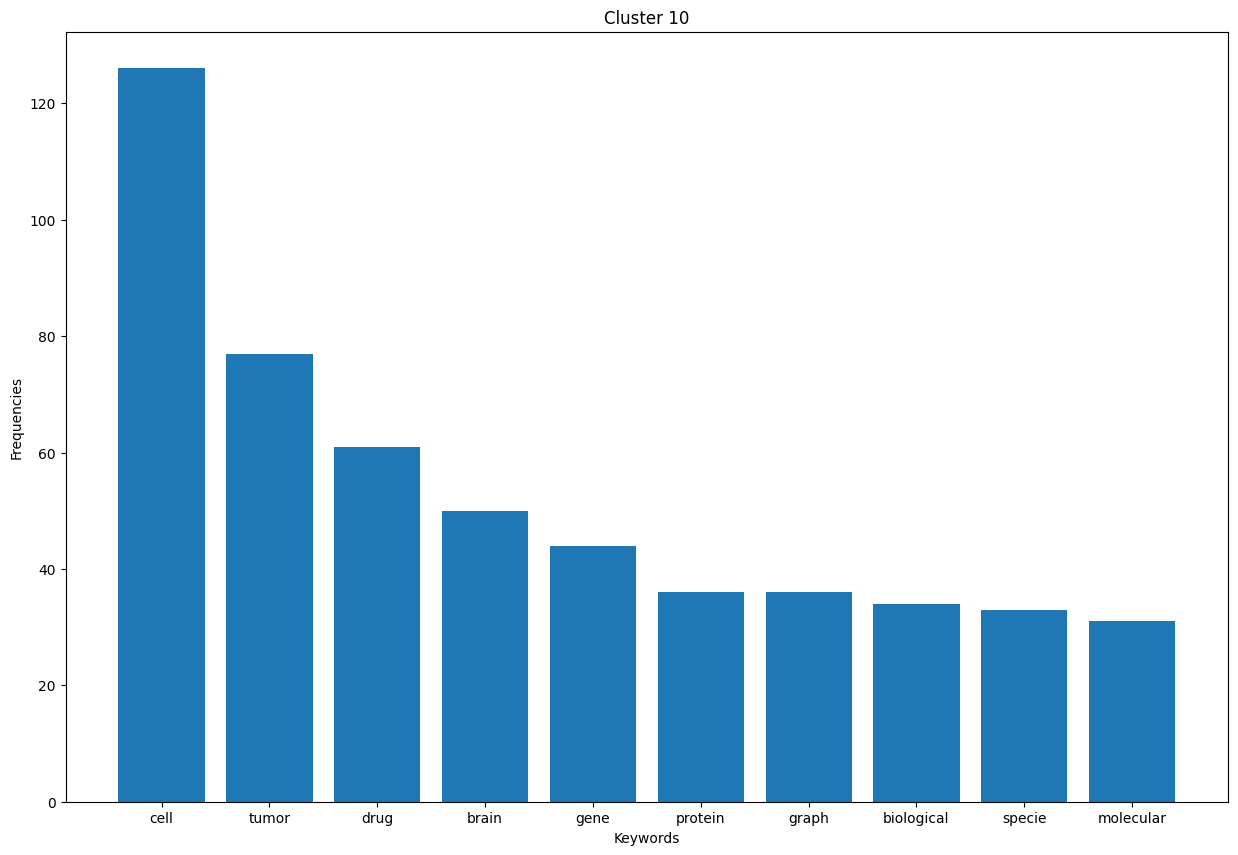

Cluster: 2
Document Count: 8500
regression : 123
selection : 87
random : 81
tree : 80
forest : 79
distribution : 76
uncertainty : 74
forecasting : 72
index : 67
statistical : 64



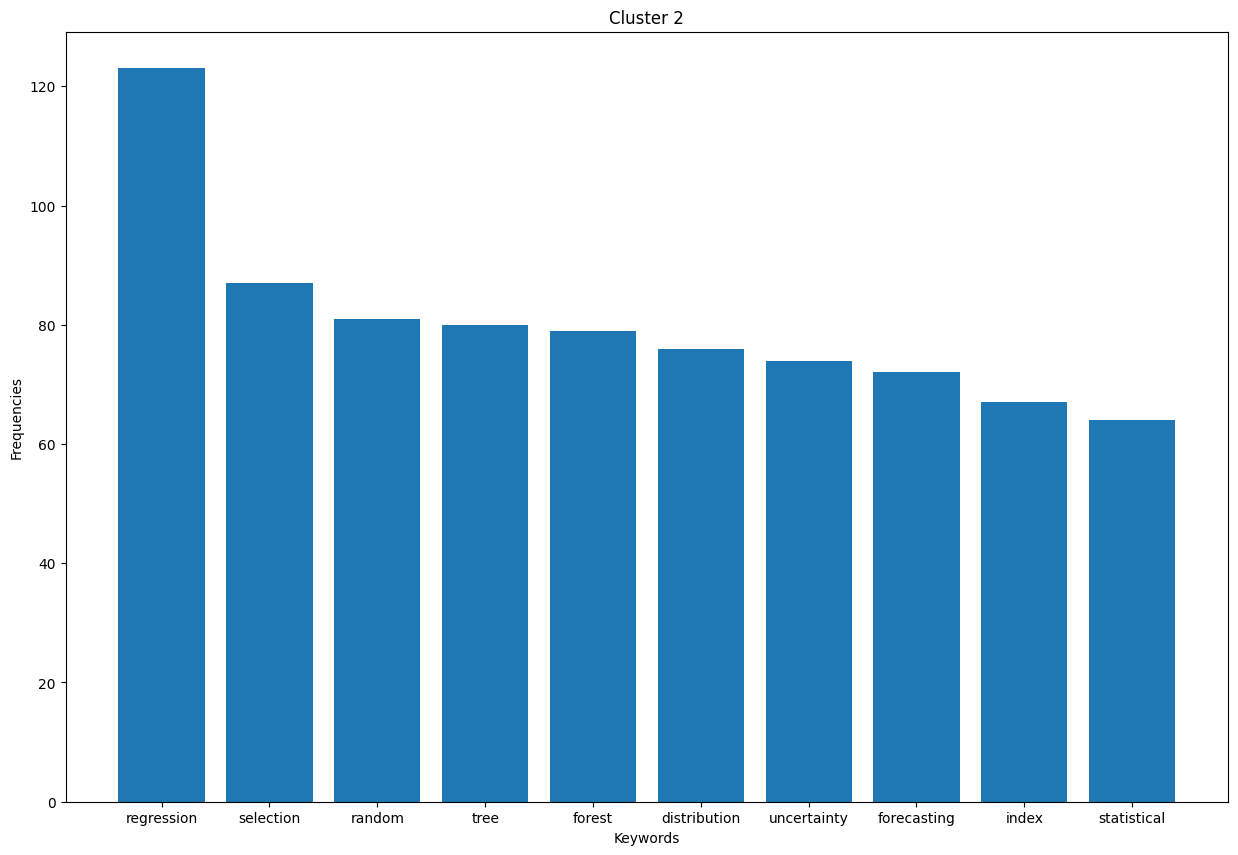

Cluster: 11
Document Count: 12296
software : 184
engineering : 144
embryo : 143
rule : 129
expert : 115
logic : 108
computational : 71
programming : 71
library : 68
general : 64



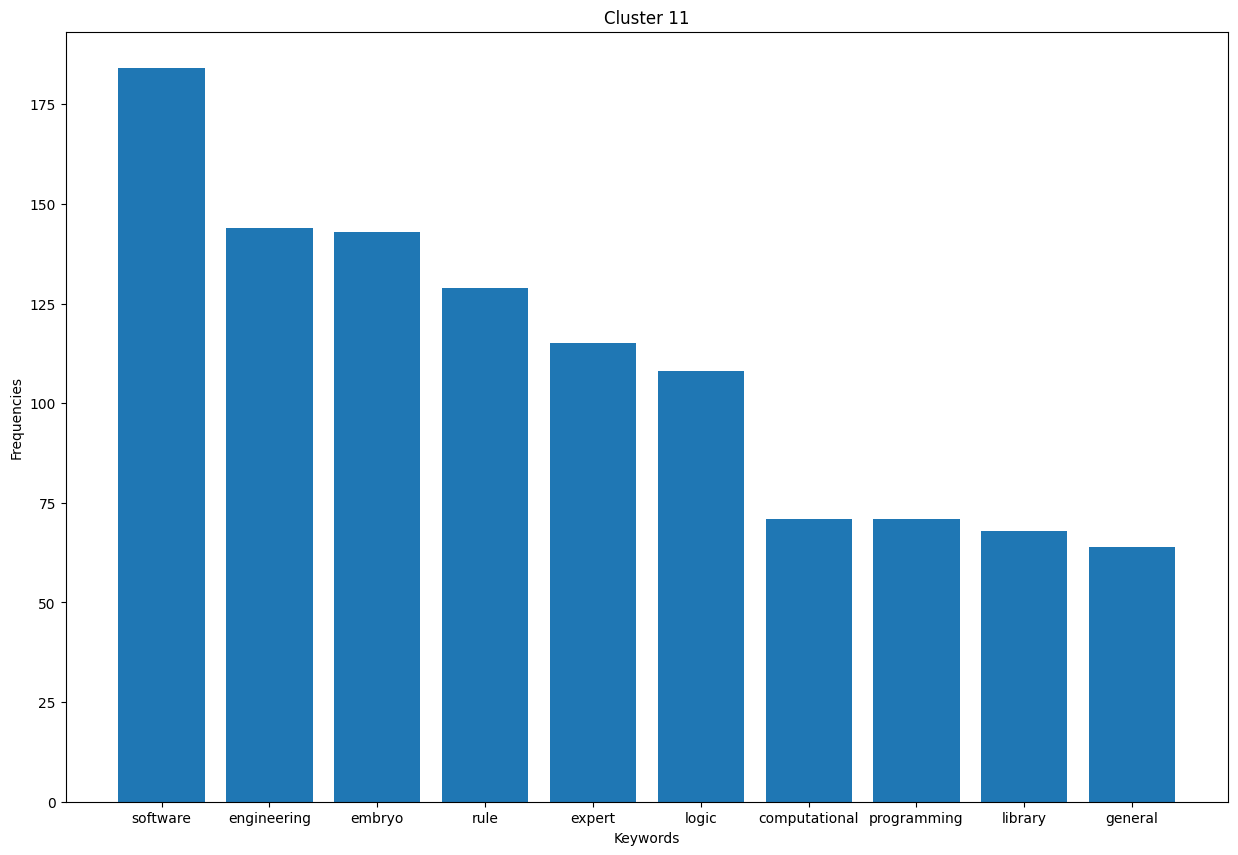

Cluster: 0
Document Count: 7201
span : 209
text : 178
breast : 153
speech : 76
mining : 71
word : 69
style : 61
semantic : 56
extraction : 55
clustering : 54



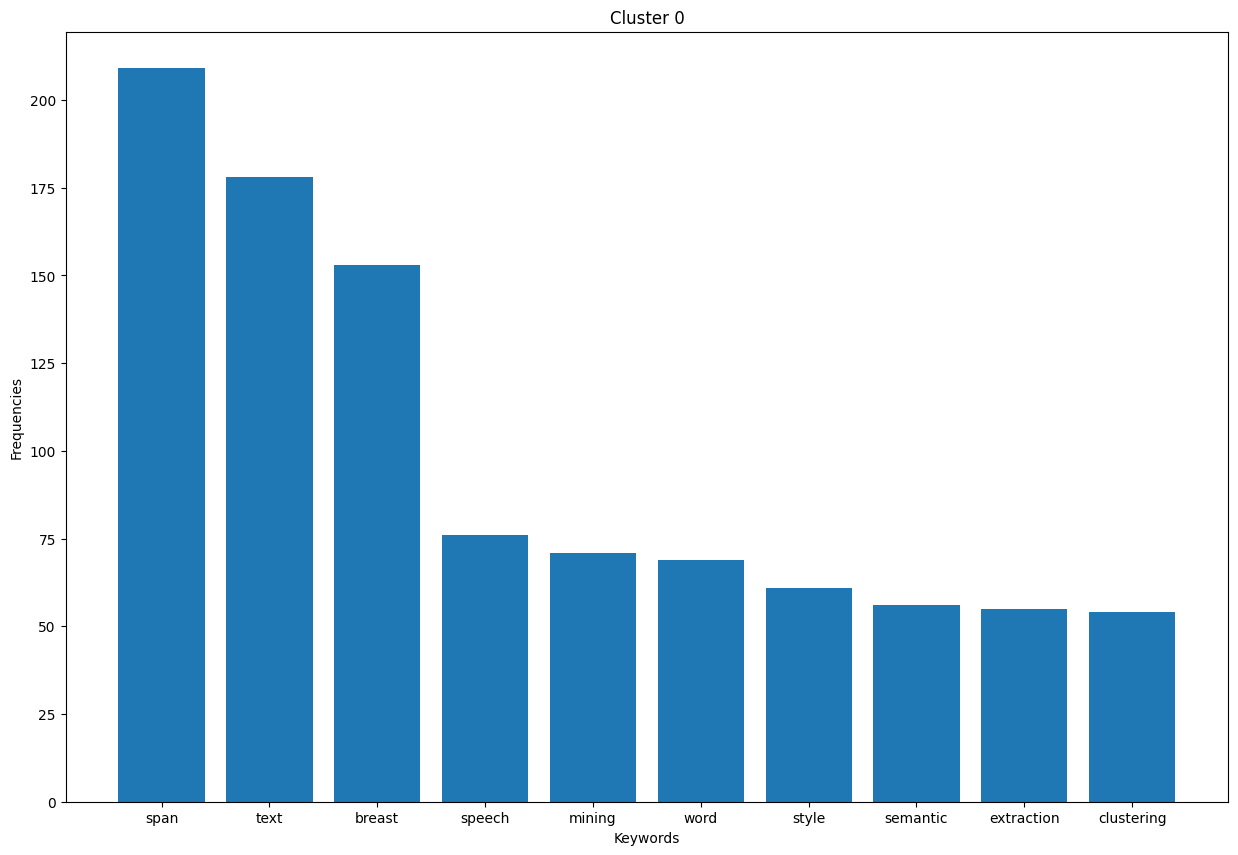

Cluster: 5
Document Count: 22190
management : 394
service : 286
digital : 278
industry : 264
business : 186
resource : 161
risk : 159
production : 152
monitoring : 149
healthcare : 132



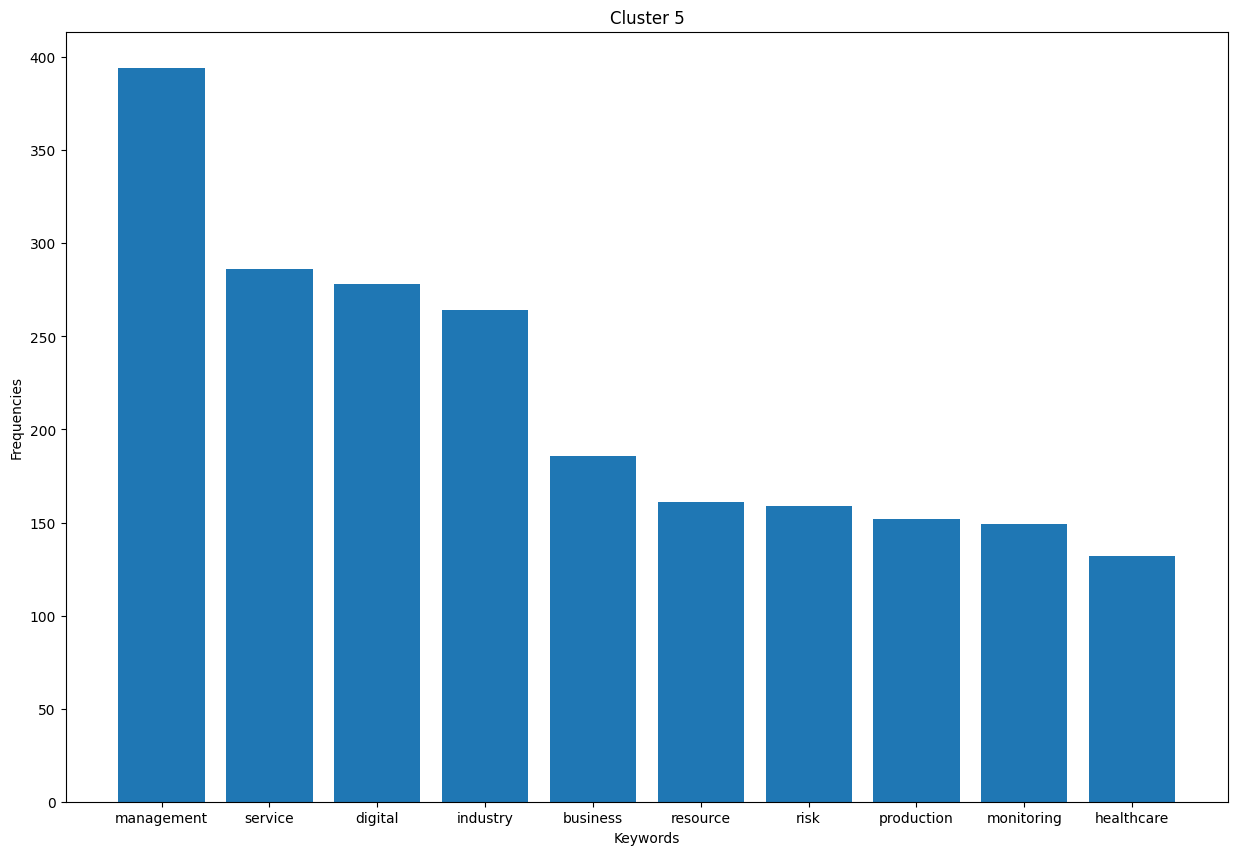

Cluster: 9
Document Count: 17247
control : 532
power : 327
robot : 314
energy : 264
sensor : 217
device : 178
dynamic : 173
month : 141
environment : 132
fault : 111



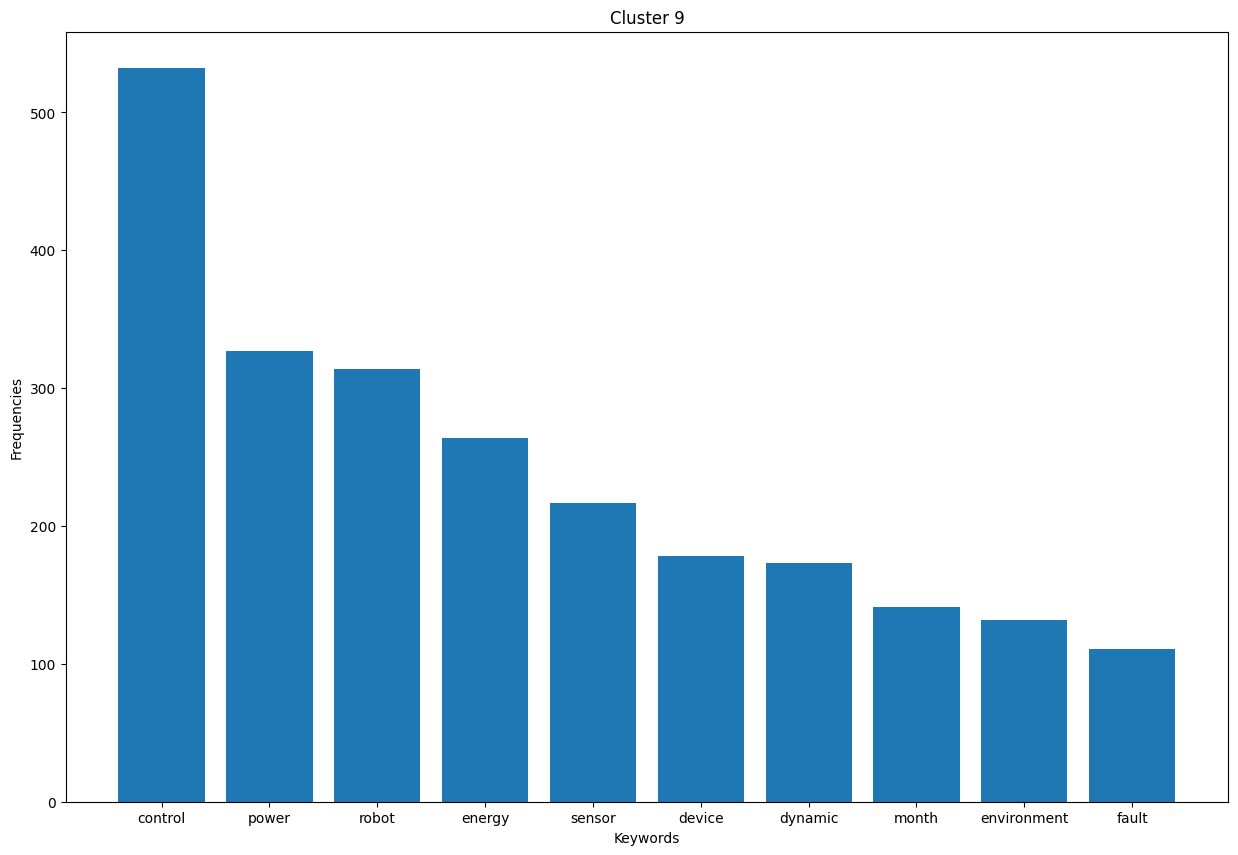

Cluster: 8
Document Count: 7139
detection : 338
vehicle : 134
video : 123
signal : 120
surface : 81
vision : 81
convolutional : 81
face : 70
traffic : 68
detect : 64



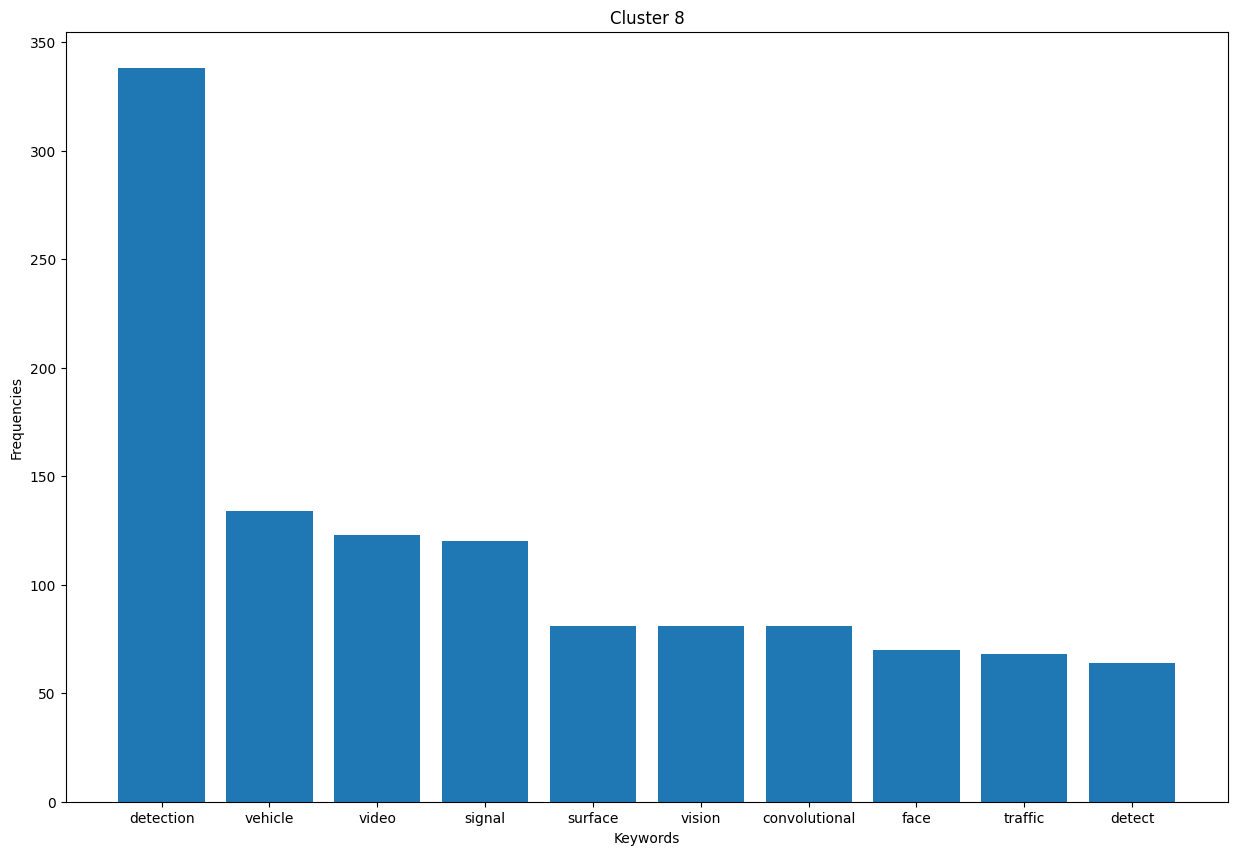

Cluster: 3
Document Count: 16441
digital : 277
social : 275
medium : 169
society : 114
scientific : 113
journal : 103
experience : 103
life : 103
public : 102
virtual : 100



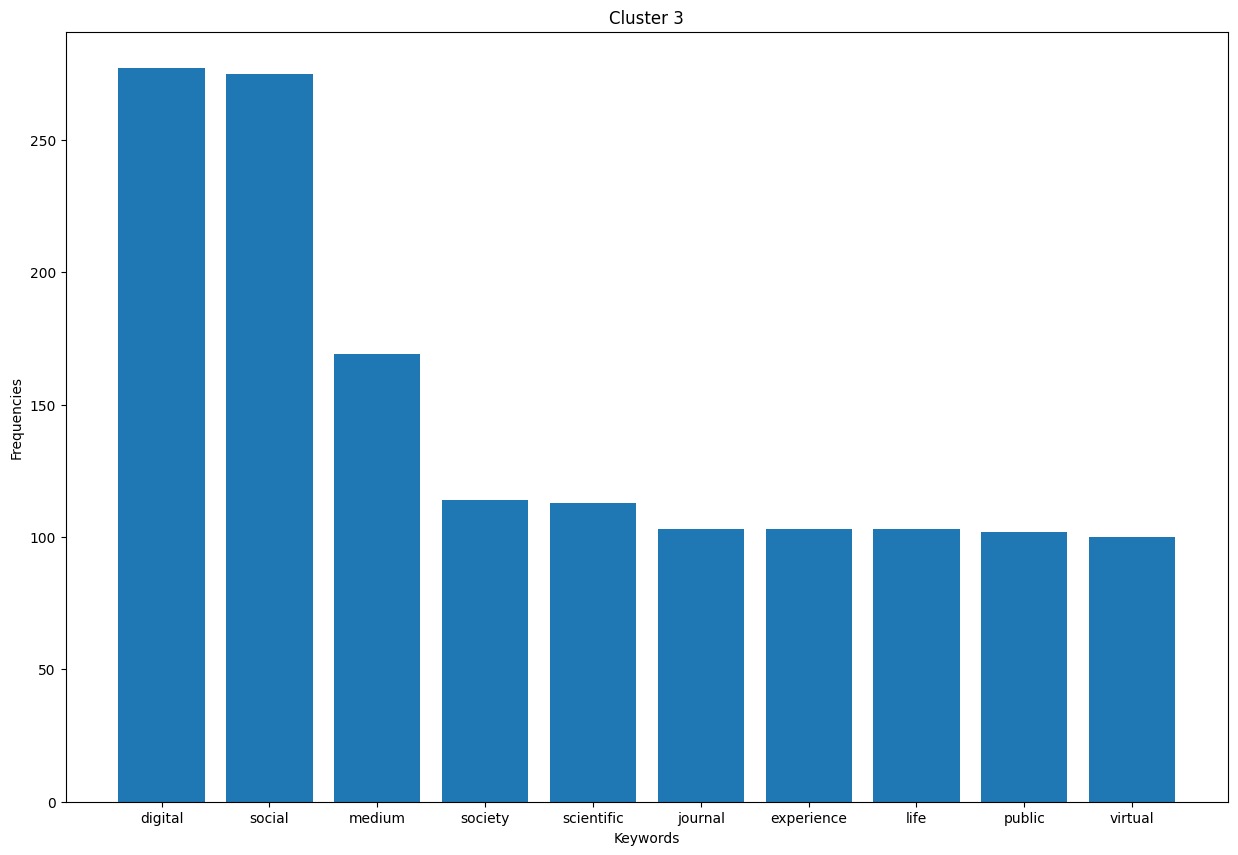

Cluster: 6
Document Count: 4602
self : 72
cognitive : 70
professor : 44
bias : 38
visual : 38
explanation : 35
employee : 34
figure : 33
body : 33
perception : 28



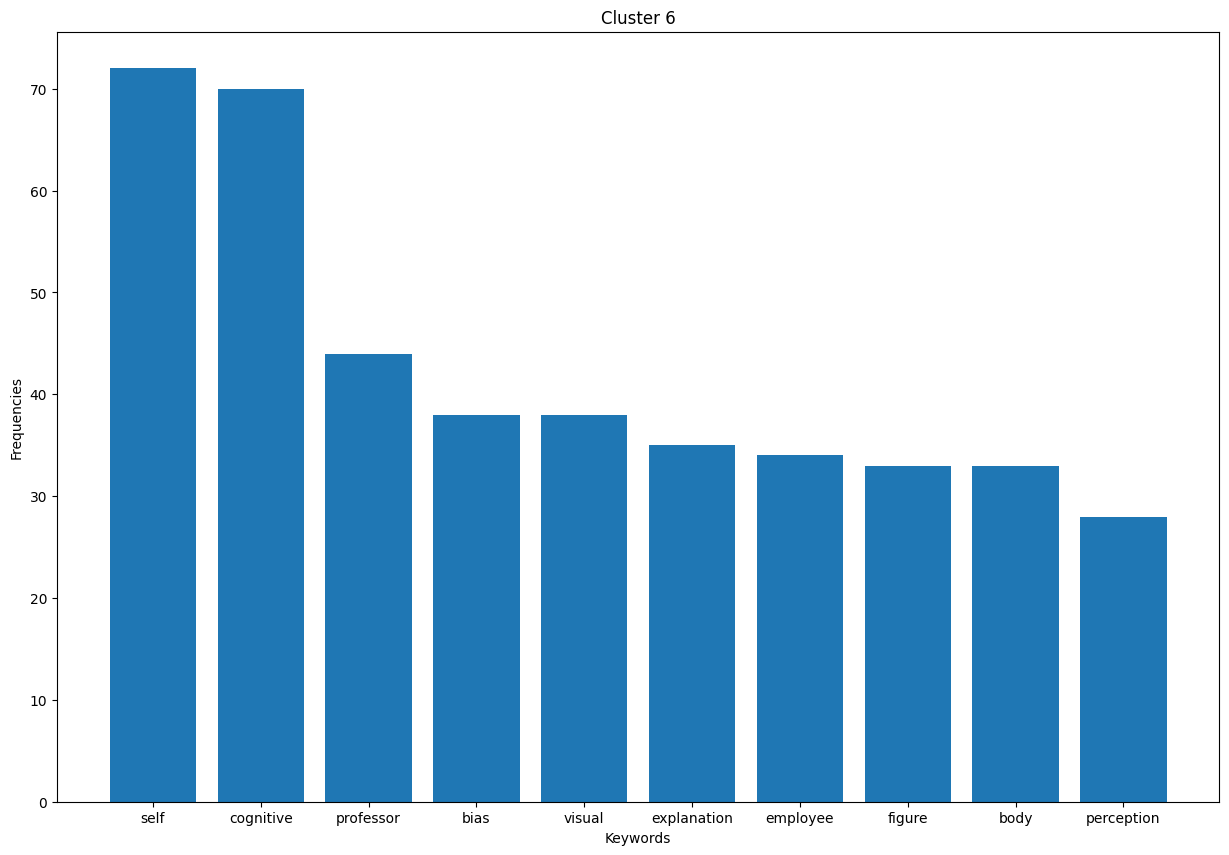

Cluster: 4
Document Count: 2024
education : 125
student : 120
university : 118
game : 64
teaching : 57
school : 57
educational : 52
child : 43
skill : 37
course : 32



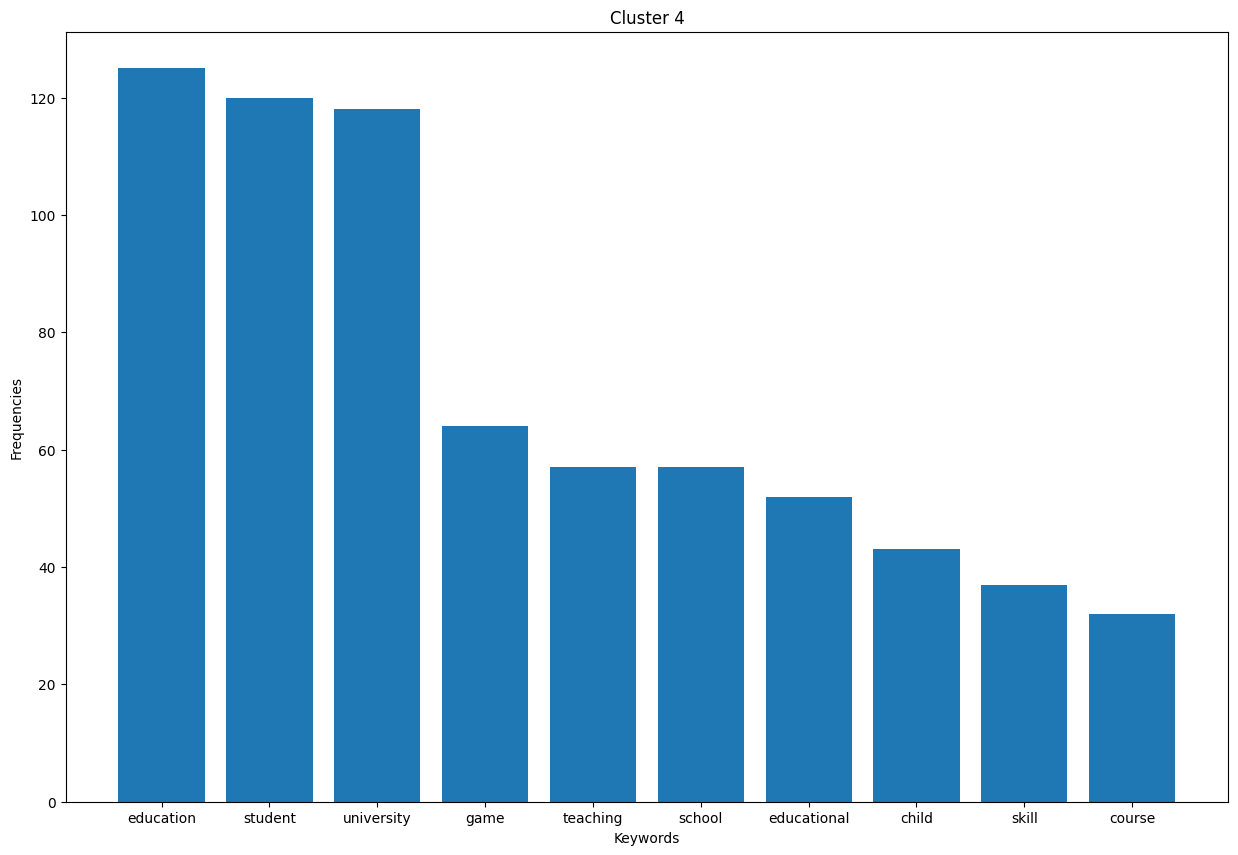

Cluster: 12
Document Count: 5708
imaging : 84
score : 81
assessment : 66
validation : 64
screening : 56
cohort : 51
sensitivity : 48
therapy : 48
showed : 44
respectively : 44



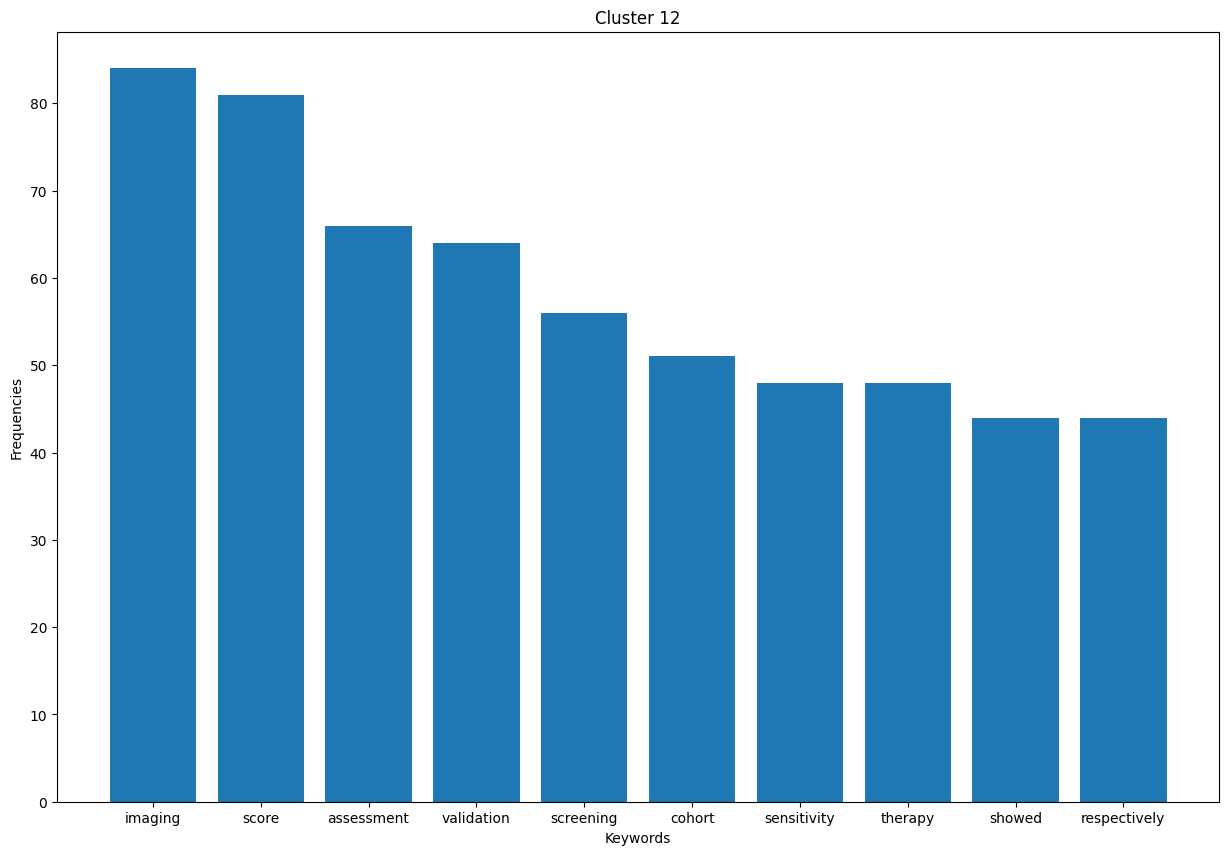

Cluster: 7
Document Count: 1117
health : 80
care : 36
record : 12
population : 12
university : 12
attack : 11
mortality : 10
funding : 9
physician : 9
participant : 9



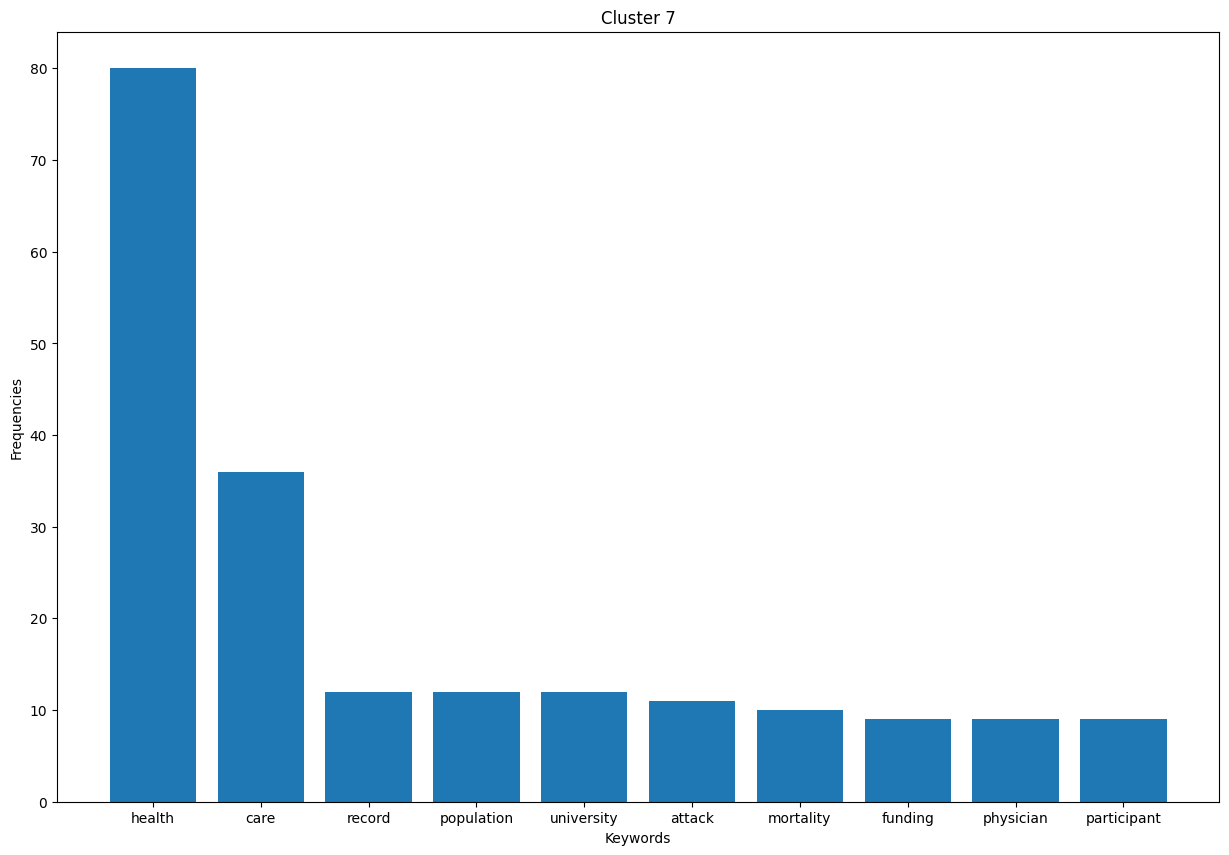

Cluster: 1
Document Count: 4981
patient : 501
clinical : 233
cancer : 223
disease : 214
medical : 162
covid : 162
diagnosis : 150
treatment : 140
risk : 87
diagnostic : 72



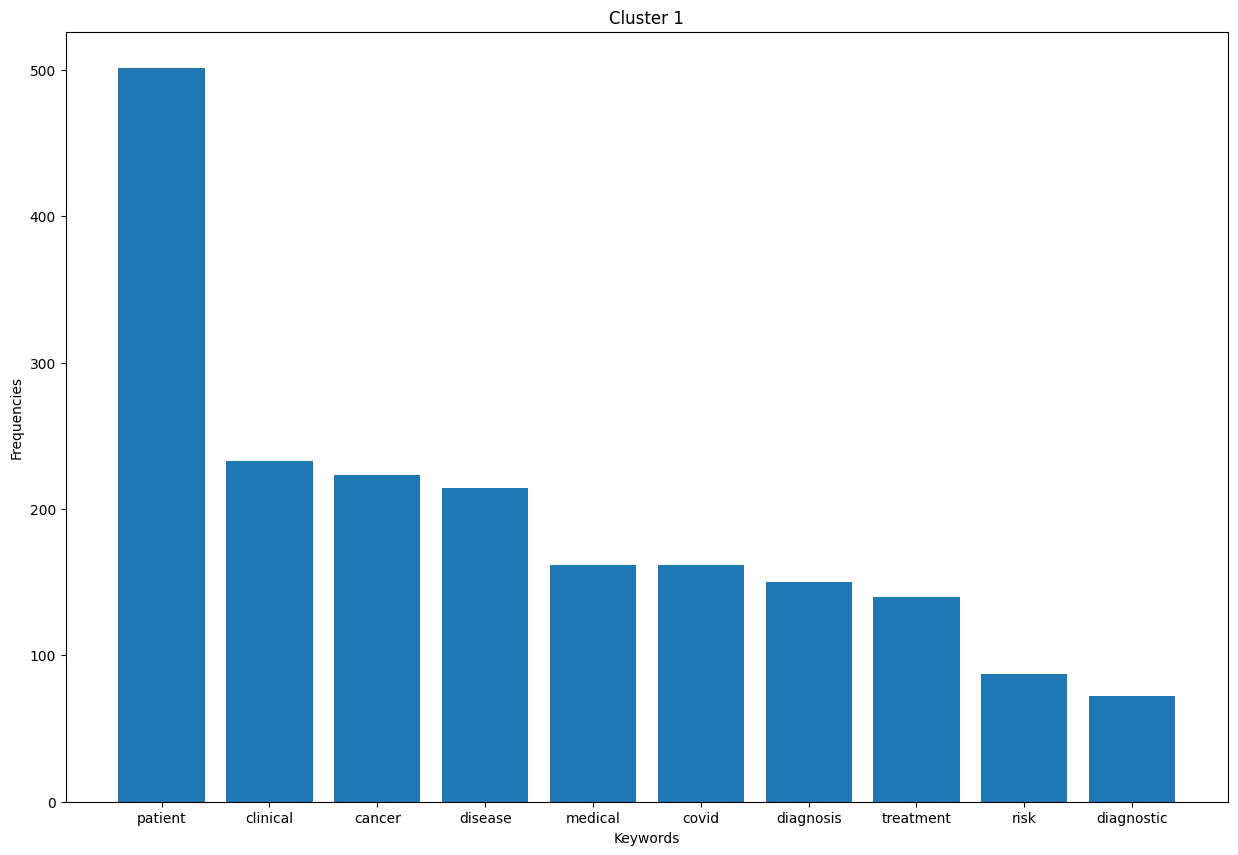

Cluster: 13
Document Count: 185
water : 14
planning : 12
reservoir : 11
emotion : 7
path : 7
quantum : 5
tourism : 4
trajectory : 4
scheduling : 3
emotional : 3



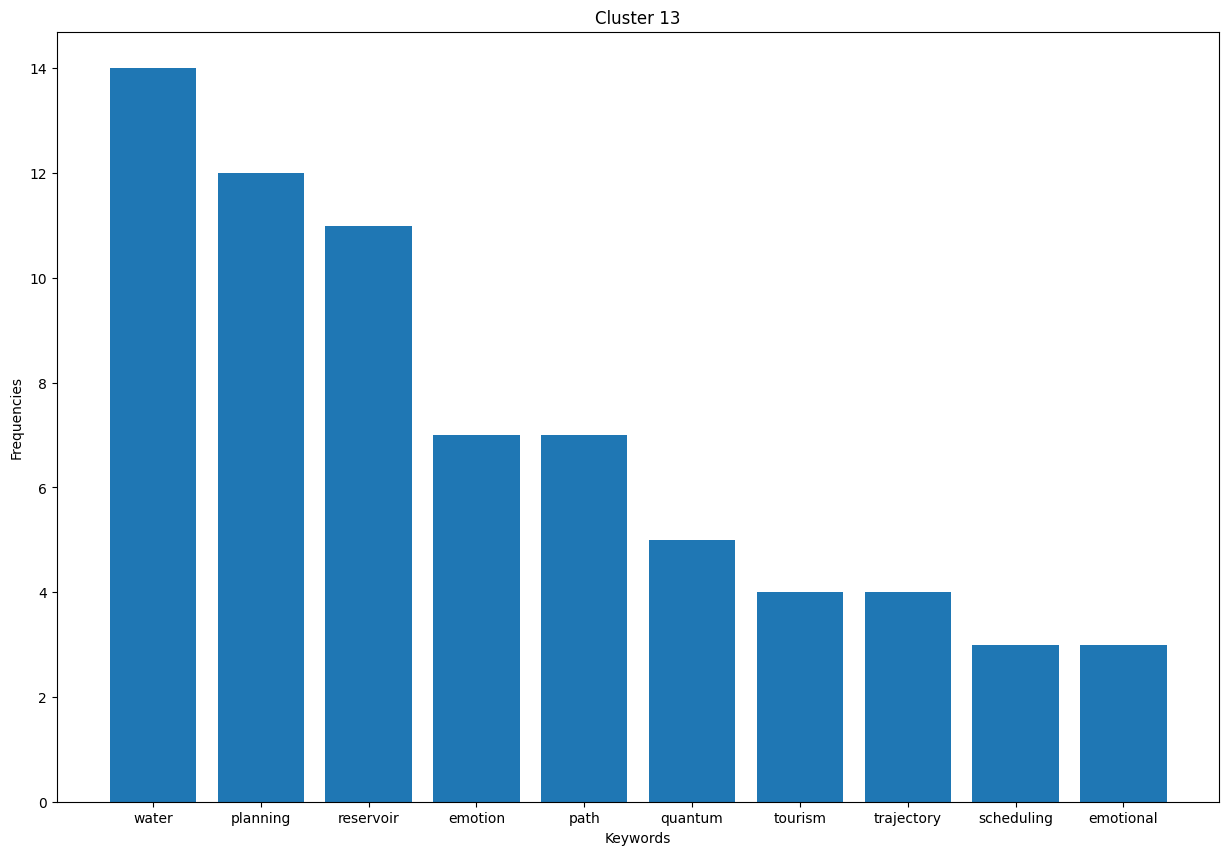

In [24]:
# Get the top keywords and their frequencies in each cluster
top_keywords = lda_model.show_topics(num_topics=len(cluster_counts), num_words=10)
for i, (topic, count) in enumerate(cluster_counts.items()):
    print("Cluster:", topic)
    print("Document Count:", count)

    # Extract the top keywords and frequencies for the current cluster
    keywords = [word for word, _ in lda_model.show_topic(topic, topn=10)]
    freqs = [int(round(count * prob)) for _, prob in lda_model.show_topic(topic, topn=10)]

    # Print the top keywords and their frequencies
    for keyword, freq in zip(keywords, freqs):
        print(keyword, ":", freq)
    print()
    plt.figure(figsize=(15, 10))
    plt.bar(keywords, freqs)
    plt.xlabel('Keywords')
    plt.ylabel('Frequencies')
    plt.title('Cluster '+ str(topic))
    plot1 = plt.gcf()
    plt.show()
    plot1.savefig("Keywords Cluster" + str(topic))


In [25]:
# Print the top keywords and their frequencies
counts = 0
for keyword, freq in zip(keywords, freqs):
  print(keyword, ":", freq)

print()


water : 14
planning : 12
reservoir : 11
emotion : 7
path : 7
quantum : 5
tourism : 4
trajectory : 4
scheduling : 3
emotional : 3



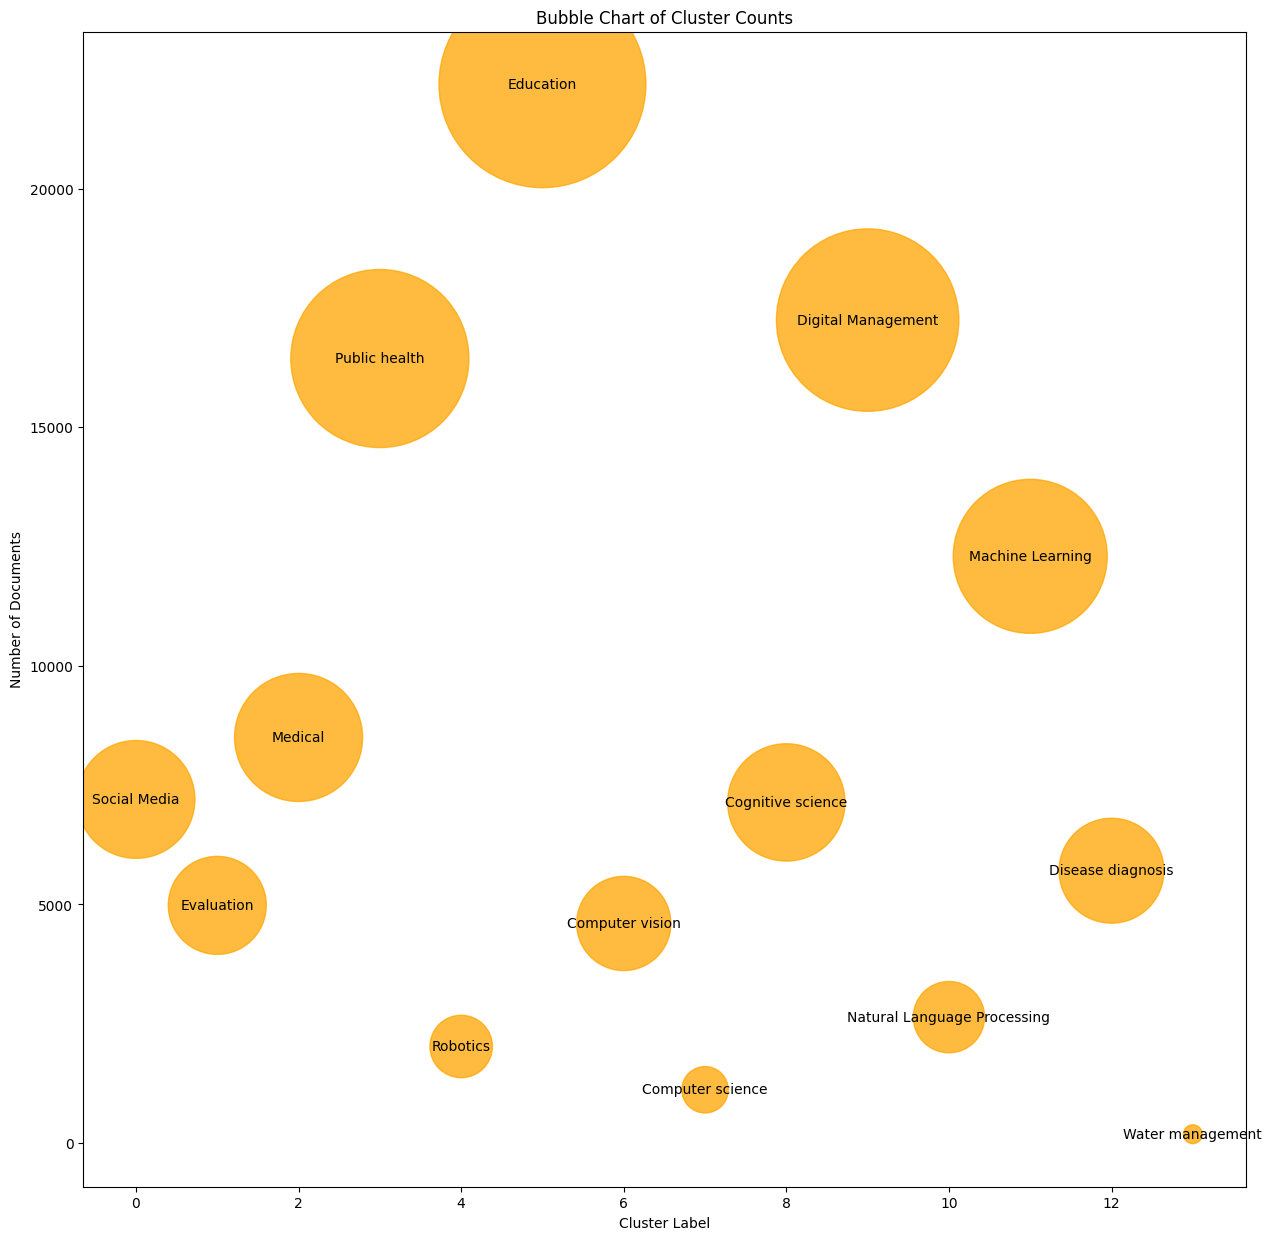

In [26]:
# Get the cluster labels and counts.
cluster_labels, cluster_counts = list(cluster_counts.keys()), list(cluster_counts.values())

# Create a bubble chart of the cluster counts, with the size of the bubbles proportional to the number of documents in each cluster.
plt.figure(figsize=(15, 15))
plt.scatter(cluster_labels, cluster_counts, s=cluster_counts, c='orange', alpha=0.75)
labels = ["Natural Language Processing","Medical", "Machine Learning", "Social Media", "Education", "Digital Management", "Cognitive science", "Public health", "Computer vision", "Robotics", "Disease diagnosis", "Computer science", "Evaluation", "Water management" ]

#Add a label to each cluster.
for i in range(len(cluster_labels)):
  plt.text(cluster_labels[i], cluster_counts[i], str(labels[i]), ha='center', va='center')
# Add a title and labels to the plot.
plt.title('Bubble Chart of Cluster Counts')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Documents')
plot2 = plt.gcf()
# Show the plot.
plt.show()
plot2.savefig("Bubble chart")

In [27]:
# LDA does soft clustering. This shows all the topics each article is assigned to
topic_assignments = []
for doc in doc_term_matrix:
    topic_dist = lda_model.get_document_topics(doc)
    topic_assignments.append([t[0] for t in topic_dist])

In [28]:
# To get the topic that an article has maximum probability of being assigned to
dominant_assignments = []

for doc in doc_term_matrix:
      topic_distribution = lda_model.get_document_topics(doc)
      topic_distribution.sort(key=lambda x: x[1], reverse=True)
      dominant_topic = max(topic_distribution, key=lambda item: item[1])[0]
      dominant_assignments.append(dominant_topic)

In [29]:
article_topic_map = {}
for i, article in enumerate(df['doi']):
    dominant_topic = dominant_assignments[i]
    if article_topic_map.get(dominant_topic) is None:
        article_topic_map[dominant_topic] = []
    article_topic_map[dominant_topic].append(article)

In [30]:
# Specify the output CSV file path
output_file = '/content/gdrive/MyDrive/Colab Notebooks/Topic_DOI_Map.csv'

# Open the file in 'w' mode, create a CSV writer object
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header
    writer.writerow(['Topic', 'DOI'])

    # Write the contents of the dictionary
    for key, value in article_topic_map.items():
        writer.writerow([key, value])

print(f"Data written to '{output_file}' successfully.")

Data written to '/content/gdrive/MyDrive/Colab Notebooks/Topic_DOI_Map.csv' successfully.


Word Cloud

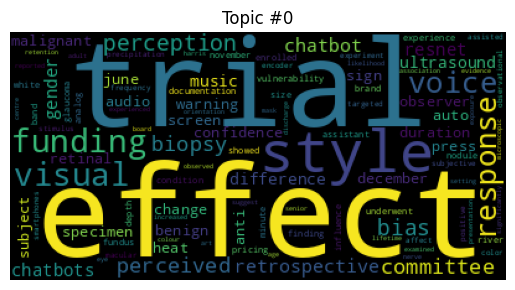

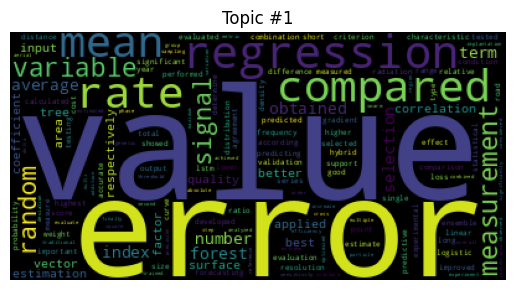

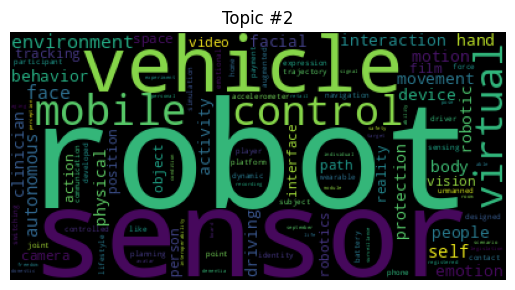

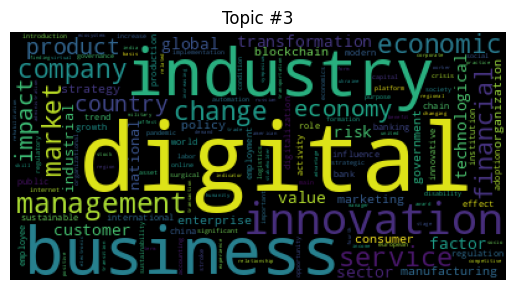

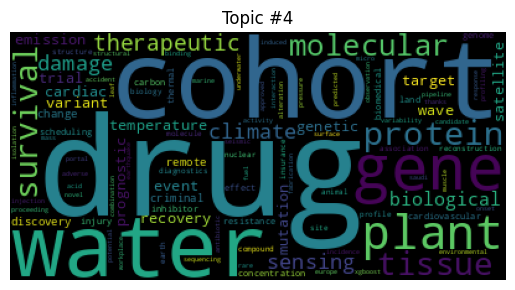

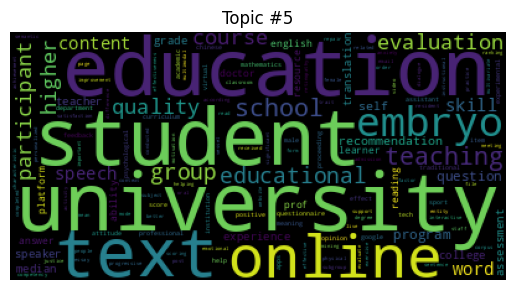

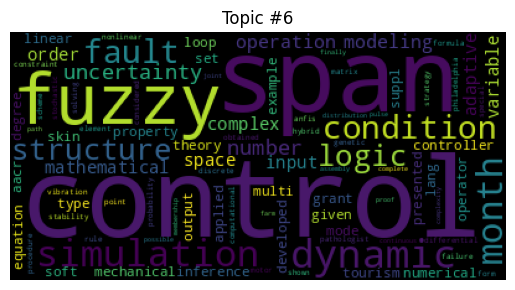

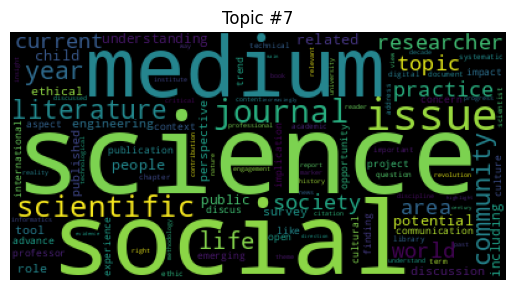

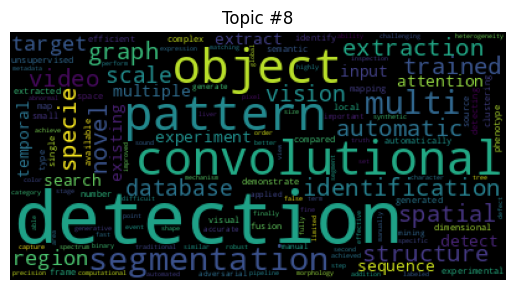

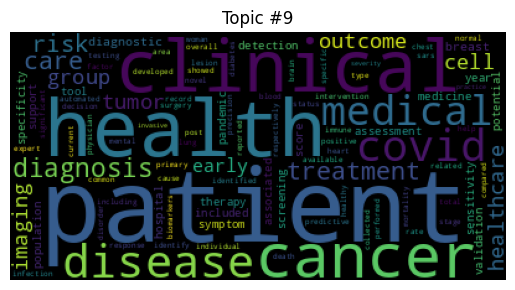

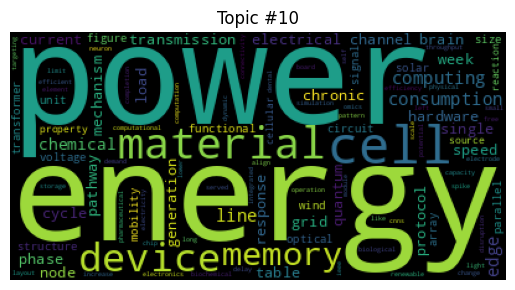

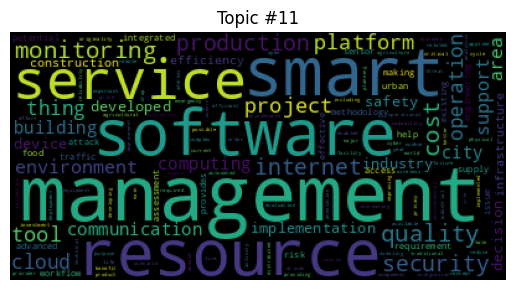

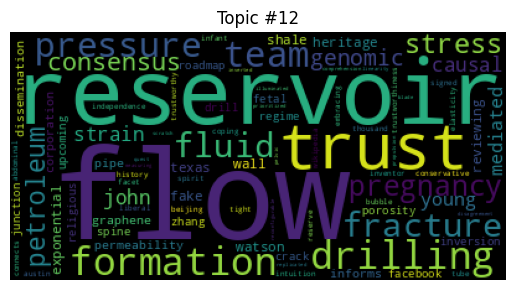

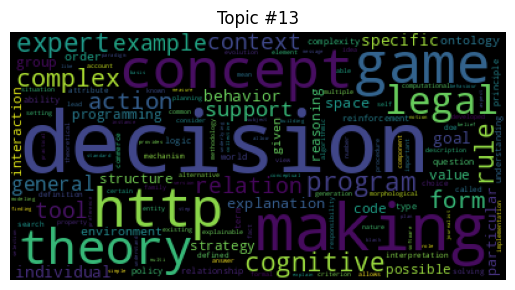

In [ ]:
for t in range(lda_model.num_topics):
    topic_words = lda_model.show_topic(t, 200)
    wordcloud_data = {word: prob for word, prob in topic_words}

    plt.figure()
    plt.imshow(WordCloud().fit_words(wordcloud_data))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()
